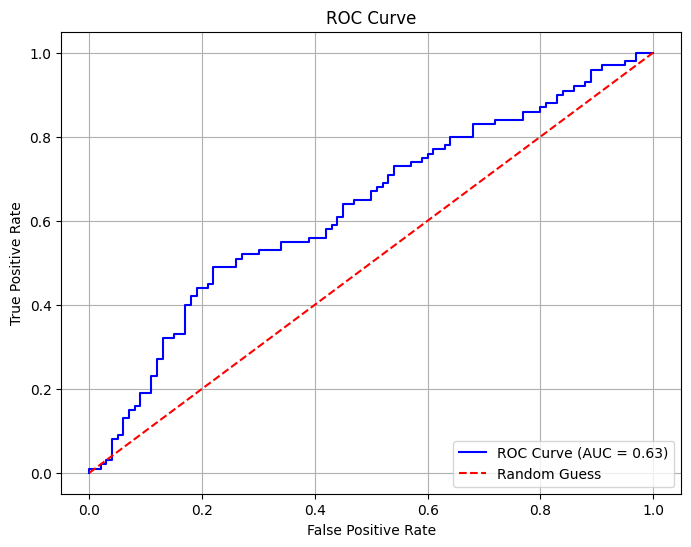

              precision    recall  f1-score   support

  Uninfected       0.52      0.93      0.67       100
    Infected       0.68      0.15      0.25       100

    accuracy                           0.54       200
   macro avg       0.60      0.54      0.46       200
weighted avg       0.60      0.54      0.46       200



In [5]:
import cv2
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Define Grad-CAM class for feature extraction and visualization
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for forward activations
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output)
        self.model.zero_grad()
        output[:, target_class].backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        weights = np.mean(gradients, axis=(2, 3))
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Preprocessing function for CNN
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Load the CNN model for feature extraction (e.g., VGG16)
def load_cnn_model():
    model = torchvision.models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=2)  # Binary classification
    model.eval()
    return model

# Extract features using CNN (adjusted for XGBoost model compatibility)
def extract_features(image_path, cnn_model, use_pca=False, target_dim=2048):
    image_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        # Extract features from the convolutional layers
        features = cnn_model.features(image_tensor)  # Convolutional part
        features = features.view(features.size(0), -1)  # Flatten the features
        
        # If PCA is needed, apply PCA for dimensionality reduction
        if use_pca:
            pca = PCA(n_components=target_dim)
            features = pca.fit_transform(features.cpu().numpy())
        else:
            # Otherwise, use a specific layer output (e.g., 2048-dim)
            features = features[:, :target_dim]
        
    return features

# Load the XGBoost model
def load_xgboost_model(model_path):
    model = xgb.Booster()  # Initialize the XGBoost Booster
    model.load_model(model_path)  # Load the model from file
    return model

# Predict with XGBoost using CNN features
def predict_with_xgboost(xgb_model, cnn_model, image_path):
    features = extract_features(image_path, cnn_model)  # Extract features from CNN
    dmatrix = xgb.DMatrix(features)  # Convert features to DMatrix for XGBoost prediction
    prediction = xgb_model.predict(dmatrix)  # Make prediction using XGBoost
    return prediction

# Function to evaluate all images in a folder (for ROC and metrics)
def evaluate_images_in_folder(xgb_model, cnn_model, folder_path):
    all_labels = []
    all_probs = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            ground_truth_label = 1 if subfolder == "infected" else 0  # Assuming folder names as labels
            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)

                # Predict with XGBoost
                prediction = predict_with_xgboost(xgb_model, cnn_model, image_path)
                all_labels.append(ground_truth_label)
                all_probs.append(prediction[0])  # Only interested in the probability of 'Infected'

    return all_labels, all_probs

# Function to plot ROC Curve
def plot_roc_curve(labels, probabilities):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    xgb_model_path = "xgboost_cancer_model.json"  # Path to your XGBoost model
    xgb_model = load_xgboost_model(xgb_model_path)
    
    cnn_model = load_cnn_model()  # Load CNN for feature extraction

    # Folder path containing images (e.g., "test_eval/infected/" and "test_eval/uninfected/")
    folder_path = "TEST_METRICS"  # Path to the parent folder containing "infected" and "uninfected"

    # Evaluate all images in the folder and collect true labels and predicted probabilities
    all_labels, all_probs = evaluate_images_in_folder(xgb_model, cnn_model, folder_path)

    # Plot ROC curve
    plot_roc_curve(all_labels, all_probs)

    # Classification report (optional)
    report = classification_report(all_labels, np.array(all_probs) > 0.5, target_names=["Uninfected", "Infected"])
    print(report)
